In [181]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
import json
from tqdm.notebook import tqdm
from scipy.stats import skew
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [182]:
with open("feature_dict.json", "r") as json_file:
    feature_dict = json.load(json_file)

In [183]:
df = pd.read_csv('train_prepared_for_cv.csv')

In [184]:
df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

In [185]:
sum(df.isna().sum())

357

In [186]:
X = df.drop(columns=['Id', 'SalePrice'])
y = df['SalePrice']

In [187]:
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
numeric_cols.remove("MSSubClass")
categorical_cols = [col for col in X.columns if col not in numeric_cols]
ordinal_encode_cols = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "Street", "Alley", "PavedDrive"]
label_encode_cols = [col for col in categorical_cols if col not in ordinal_encode_cols]
ohe_encode_cols = label_encode_cols

In [188]:
print(numeric_cols)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [189]:
print(categorical_cols)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [190]:
print(ordinal_encode_cols)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Street', 'Alley', 'PavedDrive']


In [191]:
print(label_encode_cols)

['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [192]:
print(len(categorical_cols))
print(len(ordinal_encode_cols), len(label_encode_cols), len(ohe_encode_cols))
print(len(ordinal_encode_cols) + len(label_encode_cols))
print(len(numeric_cols))
print(len(numeric_cols) + len(categorical_cols))

43
14 29 29
43
35
78


In [193]:
ordinal_mappings = {}

for col in ordinal_encode_cols:
    if col in X.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())  # Extract and preserve the order of values from the dict
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}  # Encode in the dict order
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        ordinal_mappings[col] = mapping
        
def safe_map(value, mapping):
    if value not in mapping:
        raise ValueError(f"Value '{value}' not found in the mapping!")
    return mapping[value]

def ordinal_encode_column(X, mappings):
    encoded = X.copy()
    for col in X.columns:
        if col in mappings:
            encoded[col] = X.apply(lambda x: safe_map(x, mappings[col]))
    return encoded

print(ordinal_mappings)

{'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'BsmtQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'BsmtCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'BsmtExposure': {'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5, 'No_item': -1}, 'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'FireplaceQu': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'GarageQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'GarageCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'PoolQC': {'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'Street': {'Grvl': 1, 'Pave': 2, 'No_item': -1}, 'Alley': {'Grvl': 2, 'Pave': 3, 'No_item': -1}, 'PavedDrive': {'N': 1, 'P': 2, 'Y': 3, 'No_item': -1}}


In [194]:
label_mappings = {}

for col in label_encode_cols:
    if col in X.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())  # Extract and preserve the order of values from the dict
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}  # Encode in the dict order
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        label_mappings[col] = mapping
        
def safe_map(value, mapping):
    if value not in mapping:
        raise ValueError(f"Value '{value}' not found in the mapping!")
    return mapping[value]

def label_encode_column(X, mappings):
    encoded = X.copy()
    for col in X.columns:
        if col in mappings:
            encoded[col] = df[col].apply(lambda x: safe_map(x, mappings[col]))
    return encoded

print(label_mappings)

{'MSSubClass': {'190': 1, '180': 2, '160': 3, '150': 4, '120': 5, '90': 6, '85': 7, '80': 8, '75': 9, '70': 10, '60': 11, '50': 12, '45': 13, '40': 14, '30': 15, '20': 16, 'No_item': -1}, 'MSZoning': {'RM': 1, 'RP': 2, 'RL': 3, 'RH': 4, 'I': 5, 'FV': 6, 'C': 7, 'A': 8, 'No_item': -1}, 'LotShape': {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4, 'No_item': -1}, 'LandContour': {'Low': 1, 'HLS': 2, 'Bnk': 3, 'Lvl': 4, 'No_item': -1}, 'Utilities': {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4, 'No_item': -1}, 'LotConfig': {'FR3': 1, 'FR2': 2, 'CulDSac': 3, 'Corner': 4, 'Inside': 5, 'No_item': -1}, 'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3, 'No_item': -1}, 'Neighborhood': {'Veenker': 1, 'Timber': 2, 'StoneBr': 3, 'Somerst': 4, 'SawyerW': 5, 'Sawyer': 6, 'SWISU': 7, 'OldTown': 8, 'NWAmes': 9, 'NridgHt': 10, 'NPkVill': 11, 'NoRidge': 12, 'Names': 13, 'Mitchel': 14, 'MeadowV': 15, 'IDOTRR': 16, 'Gilbert': 17, 'Edwards': 18, 'Crawfor': 19, 'CollgCr': 20, 'ClearCr': 21, 'BrkSide': 22, 'BrDale': 23, 

In [195]:
class DataFramePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, ordinal_cols, ohe_cols, label_cols, ordinal_mappings, label_mappings, features_to_scale):
        self.numeric_cols = numeric_cols
        self.ordinal_cols = ordinal_cols
        self.ohe_cols = ohe_cols
        self.label_cols = label_cols
        self.ordinal_mappings = ordinal_mappings
        self.label_mappings = label_mappings
        self.ohe_columns_names = None
        self.medians = {}
        self.modes = {}
        self.scaler = StandardScaler()
        self.features_to_scale = features_to_scale

    def fit(self, X, y=None):
        self.medians = X[self.numeric_cols].median()
        self.modes = X[self.ordinal_cols + self.ohe_cols + self.label_cols].mode().iloc[0]
        if self.ohe_cols:
            self.ohe_columns_names = []
            for col in self.ohe_cols:
                if col in feature_dict:
                    categories = feature_dict[col]["values"].keys()
                    for category in categories:
                        self.ohe_columns_names.append(f"{col}_{category}")
                else:
                    raise KeyError(f"Feature {col} not found in feature dictionary")
        return self

    def transform(self, X):
        X = X.copy()
        # filling NA
        for col in self.numeric_cols:
            X[col] = X[col].fillna(self.medians[col])
        
        # skewness = X[numeric_cols].apply(lambda x: skew(x))
        # skewness = skewness[abs(skewness) > 0.5]
        # skewed_features = skewness.index
        # X[skewed_features] = np.log1p(X[skewed_features])
    
        if X.columns.duplicated().any():
                raise ValueError(f"Duplicate column names found: {X.columns[X.columns.duplicated()].tolist()}")

        for col in self.ordinal_cols + self.ohe_cols + self.label_cols:
            X[col] = X[col].fillna(self.modes[col])
        
        for col in self.ordinal_cols:
            if col in self.ordinal_mappings:
                X[col] = X[col].map(self.ordinal_mappings[col]).fillna(-1)
            else:
                raise KeyError
        
        for col in self.label_cols:
            if col in self.label_mappings:
                X[col] = X[col].map(self.label_mappings[col]).fillna(-1)
            else:
                raise KeyError
        
        if self.features_to_scale:
            X[self.features_to_scale] = self.scaler.fit_transform(X[self.features_to_scale])

        
        if self.ohe_cols:
            ohe_encoded = pd.DataFrame(0, index=X.index, columns=self.ohe_columns_names)
            for col in self.ohe_cols:
                if col in feature_dict:
                    categories = feature_dict[col]["values"].keys()
                    for category in categories:
                        ohe_col_name = f"{col}_{category}"
                        ohe_encoded[ohe_col_name] = (X[col] == category).astype(int)
                else:
                    raise KeyError(f"Feature {col} not found in feature dictionary")
            X = X.drop(columns=self.ohe_cols)
            X = pd.concat([X, ohe_encoded], axis=1)
            
        return X

In [196]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=ohe_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols
)

In [197]:
# testing preprocessing
processed_data = preprocessor.fit_transform(X)

In [198]:
# These feature have skewness > 0.5
# skewed_cols = ['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'MasVnrArea',
#        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
#        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
#        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
#        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
#        'ScreenPorch', 'PoolArea', 'MiscVal']

In [199]:
processed_data

,LotFrontage,LotArea,Street,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLw,SaleType_ConLI,SaleType_ConLD,SaleType_Oth,SaleCondition_Normal,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Partial
0,-0.218699,-0.202770,0.064327,-0.255382,0.665646,-0.517461,1.053769,0.880629,0.533895,1.066349,...,0,0,0,0,1,0,0,0,0,0
1,0.499122,-0.086107,0.064327,-0.255382,-0.064709,2.176545,0.159469,-0.427190,-0.573757,-0.688006,...,0,0,0,0,1,0,0,0,0,0
2,-0.075135,0.081281,0.064327,-0.255382,0.665646,-0.517461,0.987524,0.832191,0.341751,1.066349,...,0,0,0,0,1,0,0,0,0,0
3,-0.457972,-0.091179,0.064327,-0.255382,0.665646,-0.517461,-1.860986,-0.717817,-0.573757,-0.688006,...,0,0,0,0,0,1,0,0,0,0
4,0.690541,0.386636,0.064327,-0.255382,1.396000,-0.517461,0.954402,0.735316,1.404192,1.066349,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,-0.362263,-0.256842,0.064327,-0.255382,-0.064709,-0.517461,0.921280,0.735316,-0.573757,-0.688006,...,0,0,0,0,1,0,0,0,0,0
1452,0.738396,0.276566,0.064327,-0.255382,-0.064709,0.380541,0.225713,0.154063,0.098746,-0.688006,...,0,0,0,0,1,0,0,0,0,0
1453,-0.170844,-0.142714,0.064327,-0.255382,0.665646,3.074547,-0.999809,1.025942,-0.573757,2.820705,...,0,0,0,0,1,0,0,0,0,0
1454,-0.075135,-0.074237,0.064327,-0.255382,-0.795063,0.380541,-0.701709,0.541565,-0.573757,-0.688006,...,0,0,0,0,1,0,0,0,0,0


Playing with models

In [206]:
def run_model(model_class, param_grid, preprocessor, X, y):
    
    kf = KFold(n_splits=9, shuffle=True, random_state=42)
    
    r2 = {"train": [], "test": []}
    mae = {"train": [], "test": []}
    best_params = []
    feature_importances = pd.DataFrame(index=X.columns)

    for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X), 1)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        preprocessor.fit(X_train)
        X_train_preprocessed = preprocessor.transform(X_train)
        X_test_preprocessed = preprocessor.transform(X_test)
                
        model = model_class()
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train_preprocessed, y_train)
        
        best_params.append(grid_search.best_params_)
        
        model = model_class(**grid_search.best_params_)
        model.fit(X_train_preprocessed, y_train)
        
        y_train_pred = model.predict(X_train_preprocessed)
        y_test_pred = model.predict(X_test_preprocessed)
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        r2["train"].append(train_r2)
        r2["test"].append(test_r2)
        mae["train"].append(train_mae)
        mae["test"].append(test_mae)
        
        # if hasattr(model, "coef_"):
        #     print(f"Model {model_class} has coef_ attribute")
        #     print(model.coef_)
        # if hasattr(model, "feature_importances_"):
        #     print(f"Model {model_class} has feature_importances_ attribute")
        #     print(model.feature_importances_)
        
        if model_class == XGBRegressor:
            gain_importance = model.get_booster().get_score(importance_type='gain')
            fold_importances = pd.Series(gain_importance)
        else:
            if hasattr(model, "coef_"):
                try:
                    fold_importances = pd.Series(np.abs(model.coef_), index=X.columns)
                except:
                    fold_importances = pd.Series(np.abs(model.coef_), index=X_train_preprocessed.columns)
                    
            elif hasattr(model, "feature_importances_"):    
                try:
                    fold_importances = pd.Series(model.feature_importances_, index=X.columns)
                except:
                    fold_importances = pd.Series(model.feature_importances_, index=X_train_preprocessed.columns)
            else:
                raise AttributeError(f"The model {model_class.__name__} does not support feature importance extraction.")
            
        feature_importances = pd.concat([feature_importances, fold_importances], axis=1)
        
    
    feature_importances['mean_importance'] = feature_importances.mean(axis=1)
    feature_importances = feature_importances[['mean_importance']].sort_values(by='mean_importance', ascending=False)
    
    return pd.DataFrame(r2), pd.DataFrame(mae), feature_importances, best_params

In [201]:
print("="*1164)

# Just testing SHAP

In [126]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [127]:
model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [128]:
gain_importance = model.get_booster().get_score(importance_type='gain')

total_gain = sum(gain_importance.values())
normalized_gain = {k: v / total_gain for k, v in gain_importance.items()}
print(normalized_gain)


{'MedInc': 0.48962251840476406, 'HouseAge': 0.07005818310434665, 'AveRooms': 0.0430909307296823, 'AveBedrms': 0.025677601231812855, 'Population': 0.024728010803848004, 'AveOccup': 0.14858008232320305, 'Latitude': 0.09029017916540252, 'Longitude': 0.10795249423694052}


In [129]:
gain_importance

{'MedInc': 24.083988189697266,
 'HouseAge': 3.4460842609405518,
 'AveRooms': 2.1195950508117676,
 'AveBedrms': 1.2630527019500732,
 'Population': 1.2163434028625488,
 'AveOccup': 7.3084893226623535,
 'Latitude': 4.4412736892700195,
 'Longitude': 5.310063362121582}

In [92]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


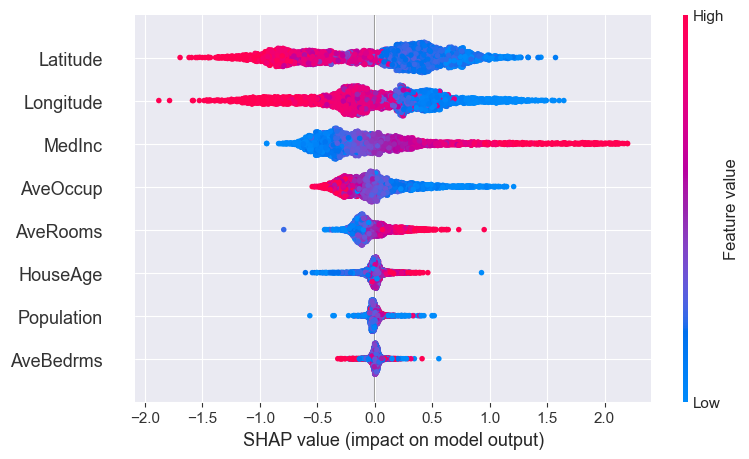

In [93]:
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [95]:
feature_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": feature_importance
}).sort_values(by="Importance", ascending=False)

print(importance_df)

      Feature  Importance
6    Latitude    0.513812
7   Longitude    0.438895
0      MedInc    0.388388
5    AveOccup    0.200593
2    AveRooms    0.126703
1    HouseAge    0.056558
4  Population    0.030340
3   AveBedrms    0.027894


In [94]:
print("="*1164)

# Label Encoding

## Label without scaling

In [207]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=[],
    label_cols=label_encode_cols,
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=[]
)

In [208]:
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-1.0,3.0,65.0,8450,2,-1,4,4,4,5,...,0,0,-1,-1,-1,0,2,2008,10,6
1,-1.0,3.0,80.0,9600,2,-1,4,4,4,2,...,0,0,-1,-1,-1,0,5,2007,10,6
2,-1.0,3.0,68.0,11250,2,-1,3,4,4,5,...,0,0,-1,-1,-1,0,9,2008,10,6
3,-1.0,3.0,60.0,9550,2,-1,3,4,4,4,...,0,0,-1,-1,-1,0,2,2006,10,5
4,-1.0,3.0,84.0,14260,2,-1,3,4,4,2,...,0,0,-1,-1,-1,0,12,2008,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,-1.0,3.0,62.0,7917,2,-1,4,4,4,5,...,0,0,-1,-1,-1,0,8,2007,10,6
1452,-1.0,3.0,85.0,13175,2,-1,4,4,4,5,...,0,0,-1,4,-1,0,2,2010,10,6
1453,-1.0,3.0,66.0,9042,2,-1,4,4,4,5,...,0,0,-1,5,3,2500,5,2010,10,6
1454,-1.0,3.0,68.0,9717,2,-1,4,4,4,5,...,0,0,-1,-1,-1,0,4,2010,10,6


In [209]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0, 0.5, 1],
    'nthread': [-1],
}

# Run the model
r2, mae, feature_importances, best_params = run_model(
    model_class=XGBRegressor, 
    param_grid=param_grid, 
    preprocessor=preprocessor, 
    X=X, 
    y=y
)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)
feature_importances

0it [00:00, ?it/s]

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


MAE:
 train     6644.921994
test     14555.004874
dtype: float64
--------------------------------------------------
R2:
 train    0.986894
test     0.915279
dtype: float64
--------------------------------------------------
Best parameters:
 [{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 1.0}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 0.5, 'reg_lambda': 0, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 

,mean_importance
OverallQual,1.932842e+11
ExterQual,1.662190e+11
GarageCars,1.272948e+11
GarageFinish,6.527696e+10
BsmtQual,3.617840e+10
...,...
MiscVal,4.309313e+08
PoolQC,3.725317e+08
Street,2.645975e+08
MSSubClass,NaN


In [155]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
r2, mae, feature_importances, best_params = run_model(model_class=Lasso, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)
feature_importances

0it [00:00, ?it/s]

Model <class 'sklearn.linear_model._coordinate_descent.Lasso'> has coef_ attribute
[ 0.00000000e+00  3.58879744e+02  8.21410884e+01  4.97736816e-01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  8.25688477e+01
  0.00000000e+00  0.00000000e+00  3.00387554e+03  0.00000000e+00
  1.17673610e+04  4.19980015e+03  3.28204436e+02  9.63642888e+01
 -1.47828655e+03  0.00000000e+00  6.93247178e+02 -6.88706642e+02
 -2.68759361e+03  5.12479430e+01  7.22464352e+03 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -3.70905236e+03  3.15957023e+03
 -2.05572053e+02  3.70791877e+01  1.71387559e+01  1.27525281e+01
  9.89301651e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  4.82745030e+01  4.71728124e+01  1.73562693e+01
  8.44619666e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -5.70452516e+03 -0.00000000e+00  3.83467268e+03
  1.59430843e+03  2.28444954e+03  0.00000000e+00  6.98332860e+02
 -1.529

,mean_importance
OverallQual,11238.493998
ExterQual,7932.347160
BedroomAbvGr,5640.297712
KitchenQual,5215.830560
BsmtCond,4563.945384
...,...
FullBath,0.000000
LotConfig,0.000000
Utilities,0.000000
Street,0.000000


In [156]:
param_grid = {}
r2, mae, feature_importances, best_params = run_model(model_class=LinearRegression, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)

0it [00:00, ?it/s]

Model <class 'sklearn.linear_model._base.LinearRegression'> has coef_ attribute
[-2.36369659e-09  2.07504683e+03  6.87702670e+01  4.92084257e-01
  1.55968036e+04 -2.29224280e+03 -1.50579177e+03 -1.32870465e+03
  2.09179118e+04  2.18143987e+00  4.47275069e+03  3.31335717e+01
  1.11159232e+03  5.85150475e+03  2.20365140e+03  5.63272181e+02
  1.04459391e+04  6.31875578e+03  2.68912195e+02 -1.98171973e+00
 -2.70441378e+03  1.02317167e+03  8.55695068e+02 -6.46157525e+02
 -2.68162593e+03  4.88254380e+01  1.01537268e+04 -3.51897971e+03
 -1.82858931e+03  2.79049587e+03 -8.22173133e+03  4.92886165e+03
 -5.13392949e+02  2.06031767e+01  4.85804208e+00 -1.90717350e+00
  2.35540453e+01 -9.52134567e+02  1.29791567e+03 -3.11720717e+03
 -2.77392039e+03  2.00733576e+01  1.98927396e+01 -8.87228604e+00
  3.10938110e+01  2.07865842e+03 -3.30781933e+03  7.85780854e+02
  9.55864109e+02 -8.27425991e+03 -1.71701443e+04  5.83373591e+03
  4.59921874e+03  4.72424791e+03  2.46100500e+03  1.10701139e+01
 -1.964963

In [44]:
X_preprocessed = preprocessor.transform(X)

X_with_const = sm.add_constant(X_preprocessed)
model = sm.OLS(y, X_with_const).fit()

p_values = model.pvalues
print("P-values:")
print(p_values)

print(model.summary())

P-values:
MSSubClass       6.001855e-01
MSZoning         1.520540e-03
LotFrontage      9.832074e-03
LotArea          2.011993e-09
Street           5.725043e-02
                     ...     
MiscVal          9.921771e-01
MoSold           4.828913e-01
YrSold           8.650006e-01
SaleType         4.853411e-01
SaleCondition    2.869239e-07
Length: 78, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     166.6
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        23:37:45   Log-Likelihood:                -16762.
No. Observations:                1456   AIC:                         3.368e+04
Df Residuals:                    1380   BIC:                         3.408e+04
D

In [45]:
p_values = model.pvalues
p_values[p_values < 0.05].sort_values()

OverallQual      1.330286e-26
BsmtFinSF1       6.109035e-17
MasVnrArea       9.647171e-16
OverallCond      8.484578e-13
TotalBsmtSF      2.166383e-12
GrLivArea        2.584427e-12
BedroomAbvGr     1.073050e-09
LotArea          2.011993e-09
MasVnrType       1.368392e-08
BsmtExposure     4.065850e-08
Functional       1.368017e-07
SaleCondition    2.869239e-07
2ndFlrSF         3.263284e-07
ExterQual        1.071197e-06
BsmtCond         2.865514e-06
1stFlrSF         7.220870e-06
Exterior1st      1.244578e-05
KitchenAbvGr     1.795990e-05
GarageType       4.503379e-05
KitchenQual      5.703156e-05
TotRmsAbvGrd     7.833238e-05
YearBuilt        1.622978e-04
BldgType         3.339370e-04
Exterior2nd      5.622406e-04
MSZoning         1.520540e-03
ScreenPorch      1.778205e-03
RoofStyle        4.077602e-03
WoodDeckSF       4.087371e-03
Alley            5.186939e-03
LotFrontage      9.832074e-03
GarageCars       2.583537e-02
GarageArea       3.135095e-02
dtype: float64

In [157]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]      
}
r2, mae, feature_importances, best_params = run_model(model_class=ElasticNet, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)
feature_importances

0it [00:00, ?it/s]

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.933e+11, tolerance: 5.985e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.024e+11, tolerance: 6.339e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

Model <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> has coef_ attribute
[ 0.00000000e+00  3.58879744e+02  8.21410884e+01  4.97736816e-01
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  8.25688477e+01
  0.00000000e+00  0.00000000e+00  3.00387554e+03  0.00000000e+00
  1.17673610e+04  4.19980015e+03  3.28204436e+02  9.63642888e+01
 -1.47828655e+03  0.00000000e+00  6.93247178e+02 -6.88706642e+02
 -2.68759361e+03  5.12479430e+01  7.22464352e+03 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -3.70905236e+03  3.15957023e+03
 -2.05572053e+02  3.70791877e+01  1.71387559e+01  1.27525281e+01
  9.89301651e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  4.82745030e+01  4.71728124e+01  1.73562693e+01
  8.44619666e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -5.70452516e+03 -0.00000000e+00  3.83467268e+03
  1.59430843e+03  2.28444954e+03  0.00000000e+00  6.98332860e+02
 -

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.104e+11, tolerance: 6.026e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.043e+11, tolerance: 6.257e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

Model <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> has coef_ attribute
[ 0.00000000e+00  2.49033904e+03  8.64315558e+01  4.95768965e-01
  7.12151384e+02 -1.40639127e+03 -1.60778394e+03 -4.34749878e+02
  7.06080654e+02  1.52956186e+02  2.15130840e+03  1.23942590e+02
  8.48208547e+02  1.51952423e+03  2.91600613e+03  4.32838636e+02
  1.00512898e+04  5.09644768e+03  2.52734384e+02  8.39923727e+01
 -2.31529717e+03  2.08439871e+02  1.14903303e+03 -9.95997827e+02
 -2.56224158e+03  5.23704644e+01  7.27475703e+03 -2.03440026e+03
 -1.67151787e+03  2.15925257e+03 -5.43004113e+03  3.77467026e+03
 -1.84825028e+02  3.33862109e+01  1.71327143e+01  1.15772396e+01
  7.90418080e+00 -6.82002032e+02  1.76013222e+03 -1.16644212e+03
 -9.12893497e+02  4.88254730e+01  4.73046973e+01  1.27312939e+01
  7.75829928e+00  7.97249082e+02 -1.52810448e+03 -8.22138606e+02
  1.38923504e+03 -6.34114798e+03 -3.01392415e+03  6.67075545e+03
  2.26366048e+03  4.88981808e+03  9.12994273e+02  5.42514123e+02
 -

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.036e+11, tolerance: 6.133e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.151e+11, tolerance: 5.973e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

Model <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> has coef_ attribute
[ 0.00000000e+00  2.13831366e+03  1.00858989e+02  4.62901506e-01
  8.79965554e+02 -2.04601181e+03 -1.22981675e+03 -1.07797306e+03
  6.17297259e+02  6.60514612e+01  1.85471176e+03  1.18462105e+02
  5.19812915e+02  7.13501586e+02  2.94610625e+03  7.89964154e+02
  1.04446875e+04  5.34637718e+03  2.72750792e+02  7.12917024e+01
 -2.85114117e+03 -3.56113733e+02  1.06695086e+03 -9.25182194e+02
 -2.06615125e+03  4.40255319e+01  6.82138261e+03 -2.20036082e+03
 -1.40566776e+03  1.15211877e+03 -5.78559630e+03  4.24196916e+03
 -3.50509021e+02  3.63600012e+01  2.04455230e+01  1.38831303e+01
  1.00247834e+01 -5.18685920e+02  1.48462289e+03 -4.66025130e+02
 -1.02859089e+03  4.51675338e+01  4.75432462e+01  6.58760771e+00
  8.24643272e+00  3.96272038e+02 -1.20991814e+03 -5.06327616e+02
  1.53336727e+03 -6.71014098e+03 -3.36148534e+03  6.23802826e+03
  2.24223590e+03  3.88756160e+03  8.25233992e+02  6.33939867e+02
 -

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.961e+11, tolerance: 6.103e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.855e+11, tolerance: 5.813e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

Model <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> has coef_ attribute
[ 0.00000000e+00  2.40713168e+03  1.04083203e+02  4.67116449e-01
  5.22701101e+02 -1.96030328e+03 -4.65135627e+02 -4.51397399e+02
  6.03169989e+02  2.77916378e+02  1.57840842e+03  1.28318410e+02
  7.83464713e+02  1.21815245e+03  2.93938627e+03  7.80022516e+02
  1.05795753e+04  5.27885135e+03  2.53333614e+02  7.95739621e+01
 -2.41907618e+03  2.31996068e+02  8.50277484e+02 -7.37049896e+02
 -2.21936687e+03  4.58208818e+01  6.69263174e+03 -1.28953563e+03
 -1.76847756e+03  6.62292459e+02 -5.20968418e+03  4.24140333e+03
 -2.06580179e+02  3.35831838e+01  1.99730280e+01  1.32088395e+01
  9.29313254e+00 -6.86450475e+02  1.38961117e+03 -3.35049258e+02
 -1.01818035e+03  4.58427510e+01  4.86752388e+01  1.40894568e+01
  7.52265098e+00  1.28436948e+03 -2.10296850e+03 -3.94144628e+02
  8.23806104e+02 -6.20593289e+03 -3.39327491e+03  5.53073059e+03
  1.85994457e+03  4.76342682e+03  1.66869562e+03  6.23613375e+02
 -

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+11, tolerance: 5.983e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.789e+11, tolerance: 5.704e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

Model <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> has coef_ attribute
[ 0.00000000e+00  2.18438747e+03  7.09293108e+01  5.24210476e-01
  1.01054624e+03 -1.77480221e+03 -1.20834699e+03 -1.52026348e+03
  0.00000000e+00 -9.04028357e+00  9.37645602e+02  5.90520591e+01
  4.32358445e+02  1.10976562e+03  3.11167664e+03  7.86651686e+02
  1.03086674e+04  5.48572761e+03  2.98891606e+02  1.03702238e+02
 -2.24908538e+03  8.92494373e+02  1.06353134e+03 -9.52198549e+02
 -2.01623133e+03  4.38615157e+01  6.77817264e+03 -2.34144003e+03
 -2.21805756e+03  1.79878926e+03 -5.93583220e+03  4.20799524e+03
 -4.69164594e+02  3.44509973e+01  1.75912374e+01  1.26881910e+01
  9.01645279e+00 -1.21950032e+03  1.43197505e+03 -7.26406249e+02
 -1.54962084e+03  4.59544592e+01  4.69307446e+01  1.70229150e+01
  7.29489433e+00  3.10002342e+02 -1.58823282e+03 -5.32198924e+02
  3.44838847e+02 -5.95566935e+03 -3.45010781e+03  5.92577524e+03
  2.45822414e+03  5.21085634e+03  1.05149678e+03  7.19107110e+02
 -

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.609e+11, tolerance: 6.190e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e+11, tolerance: 6.245e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

Model <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> has coef_ attribute
[ 0.00000000e+00  1.93147448e+03  8.58839242e+01  4.66389770e-01
  8.76358363e+02 -1.39817960e+03 -1.32653154e+03 -1.65128460e+03
  6.32168079e+02 -6.94121703e+01  5.02368935e+02  1.20212024e+02
  8.70466253e+02 -3.90801810e+02  3.09581543e+03  7.52955226e+02
  9.64021117e+03  5.56825963e+03  3.24452605e+02  8.60006645e+01
 -2.35045355e+03  8.80990530e+02  1.06876927e+03 -1.01462725e+03
 -2.33712070e+03  5.13766341e+01  6.79183745e+03 -2.08204242e+03
 -1.40604956e+03  1.63621670e+03 -4.34272428e+03  3.94795474e+03
 -3.08055050e+02  3.32196944e+01  1.63166147e+01  1.07709145e+01
  7.95840010e+00 -4.60054246e+02  1.50658793e+03 -1.35671319e+03
 -1.37955070e+03  4.86854951e+01  4.66579003e+01 -7.48363050e+00
  7.90432602e+00  1.08553779e+03 -8.84617715e+02 -1.77234694e+02
  8.93270185e+02 -5.78389477e+03 -3.58020887e+03  6.17531165e+03
  2.02244864e+03  4.45201262e+03  3.32923073e+00  9.68503851e+02
 -

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.963e+11, tolerance: 5.949e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.819e+11, tolerance: 6.150e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

Model <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> has coef_ attribute
[ 0.00000000e+00  2.33149904e+03  4.43070463e+01  6.27354077e-01
  3.91370642e+02 -1.99352761e+03 -1.62767595e+03 -8.49711570e+02
  6.16813687e+02 -3.50430042e+02  1.52673943e+03  8.88035823e+01
  1.11994916e+03  1.41164013e+03  2.40588126e+03  4.89069483e+02
  1.04946733e+04  5.42074775e+03  2.72700880e+02  9.74782770e+01
 -2.35374959e+03  7.20883979e+02  9.94305428e+02 -8.36389247e+02
 -2.36586678e+03  4.32973849e+01  7.53354108e+03 -1.71823233e+03
 -1.86024526e+03  1.25577172e+03 -4.75124681e+03  3.17742925e+03
 -5.07469426e+02  3.58486897e+01  1.73119272e+01  1.27632354e+01
  8.61861911e+00 -8.93505798e+02  1.94049239e+03 -8.62567299e+02
 -1.33516705e+03  4.94851044e+01  4.81940746e+01  1.41527960e+01
  8.02324414e+00  1.53583321e+03 -1.44772522e+03 -1.27560191e+03
  9.02027777e+02 -6.20678946e+03 -3.49202883e+03  5.87658641e+03
  1.79118082e+03  5.10479373e+03  5.53336140e+02  7.71713388e+02
 -

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.909e+11, tolerance: 5.811e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.750e+11, tolerance: 5.906e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

Model <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> has coef_ attribute
[ 0.00000000e+00  2.46208760e+03  1.22591872e+02  5.03799080e-01
  8.30987030e+02 -1.73045569e+03 -1.21972115e+03 -6.65627936e+02
  6.18465642e+02  9.51793640e+01  9.05866292e+02  1.26362980e+02
  1.00380633e+03  1.50624024e+03  2.98642970e+03  8.46702156e+02
  1.03349335e+04  4.84975499e+03  2.95925539e+02  8.56100750e+01
 -2.64768367e+03  1.25579610e+03  1.12252018e+03 -1.04150627e+03
 -2.29470845e+03  4.80477968e+01  6.93621799e+03 -1.25607982e+03
 -1.96808111e+03  9.87607096e+02 -5.75517325e+03  4.19154427e+03
 -2.12725122e+02  3.43506316e+01  2.07140537e+01  1.47444927e+01
  1.05771164e+01 -7.06755866e+02  1.66068455e+03 -9.06935861e+02
 -1.25541497e+03  4.22414909e+01  4.88476037e+01  3.02130595e+01
  8.16586469e+00  9.87617745e+02 -2.57601162e+02  7.53831495e+01
  2.18372283e+02 -5.93945832e+03 -3.24953522e+03  5.95518269e+03
  1.77280531e+03  4.31205393e+03  1.31232103e+03  4.32885133e+02
 -

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.988e+11, tolerance: 6.259e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.079e+11, tolerance: 6.279e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

Model <class 'sklearn.linear_model._coordinate_descent.ElasticNet'> has coef_ attribute
[ 0.00000000e+00  2.42750442e+03  8.83748103e+01  4.70546994e-01
  7.50025259e+02 -1.55627729e+03 -1.27837592e+03 -1.31072361e+03
  6.44621050e+02  3.18680215e+01  1.56388815e+03  1.82942111e+02
  1.16909867e+03  1.41377907e+03  2.82006832e+03  7.03661541e+02
  1.01192337e+04  5.23366609e+03  3.00483412e+02  9.81764535e+01
 -2.58021327e+03  2.87189836e+02  8.87646476e+02 -7.64677351e+02
 -2.49436786e+03  4.88286123e+01  7.28511029e+03 -2.28979139e+03
 -1.28584952e+03  1.25038950e+03 -4.71085273e+03  3.83521856e+03
 -4.52410758e+02  3.49372290e+01  1.75264545e+01  1.14711499e+01
  8.20023921e+00 -9.08921846e+02  1.81405256e+03 -7.57816041e+02
 -1.61011800e+03  4.83256467e+01  4.82502760e+01  1.21291063e+01
  7.04037564e+00  1.36530011e+03 -1.53154756e+03 -5.65769947e+02
  3.78919434e+02 -6.12758345e+03 -3.30477854e+03  5.43363647e+03
  1.74464509e+03  4.95354169e+03  1.27777917e+03  5.48864010e+02
 -

,mean_importance
OverallQual,10415.625850
ExterQual,7037.588259
BedroomAbvGr,6108.349149
KitchenQual,5737.853272
OverallCond,5164.403601
...,...
GrLivArea,7.822476
EnclosedPorch,7.197661
MiscVal,0.770642
LotArea,0.501758


In [54]:
# stepwise
X_preprocessed = preprocessor.fit_transform(X)

model = LinearRegression()

cv = KFold(n_splits=9, shuffle=True, random_state=42)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='r2')
rfecv.fit(X_preprocessed, y)

RFECV(cv=KFold(n_splits=9, random_state=42, shuffle=True),
      estimator=LinearRegression(), scoring='r2')

In [55]:
len(rfecv.support_)

78

In [56]:
rfecv.cv_results_

{'mean_test_score': array([0.50899034, 0.58581997, 0.60247984, 0.61789489, 0.65020509,
        0.72556509, 0.72533803, 0.73534649, 0.77395396, 0.78379655,
        0.79713006, 0.80416675, 0.80670943, 0.82374272, 0.82418063,
        0.8260187 , 0.82589709, 0.82949681, 0.83084042, 0.83125641,
        0.83475836, 0.83540233, 0.83629188, 0.83716184, 0.83965907,
        0.84279484, 0.84346154, 0.84542853, 0.84908847, 0.85260801,
        0.85215824, 0.85271378, 0.85463816, 0.85465773, 0.85335114,
        0.85478265, 0.85589964, 0.85369157, 0.85435425, 0.8565615 ,
        0.85562237, 0.85595212, 0.85848871, 0.85501167, 0.8577167 ,
        0.85702844, 0.83034722, 0.83101054, 0.84949536, 0.85522281,
        0.85747054, 0.85254241, 0.86392992, 0.86622855, 0.86402414,
        0.87034036, 0.86444058, 0.87050134, 0.86897298, 0.87051824,
        0.87363302, 0.87321682, 0.87569035, 0.87722786, 0.8729072 ,
        0.87845789, 0.87745282, 0.87816724, 0.87431762, 0.87874036,
        0.87770899, 0.8795365

In [50]:
rfecv.ranking_

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [51]:
X_preprocessed.columns[rfecv.support_] # selected features

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'Enc

In [263]:
print("="*1164)

# label with scaling

In [58]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=[],
    label_cols=label_encode_cols,
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols
)

In [59]:
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-1.0,3.0,-0.218699,-0.202770,0.064327,-0.255382,4,4,4,5,...,-0.270606,-0.058115,-0.056627,-1,-1,-0.087809,-1.603837,0.137472,10,6
1,-1.0,3.0,0.499122,-0.086107,0.064327,-0.255382,4,4,4,2,...,-0.270606,-0.058115,-0.056627,-1,-1,-0.087809,-0.491667,-0.615009,10,6
2,-1.0,3.0,-0.075135,0.081281,0.064327,-0.255382,3,4,4,5,...,-0.270606,-0.058115,-0.056627,-1,-1,-0.087809,0.991227,0.137472,10,6
3,-1.0,3.0,-0.457972,-0.091179,0.064327,-0.255382,3,4,4,4,...,-0.270606,-0.058115,-0.056627,-1,-1,-0.087809,-1.603837,-1.367490,10,5
4,-1.0,3.0,0.690541,0.386636,0.064327,-0.255382,3,4,4,2,...,-0.270606,-0.058115,-0.056627,-1,-1,-0.087809,2.103397,0.137472,10,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,-1.0,3.0,-0.362263,-0.256842,0.064327,-0.255382,4,4,4,5,...,-0.270606,-0.058115,-0.056627,-1,-1,-0.087809,0.620503,-0.615009,10,6
1452,-1.0,3.0,0.738396,0.276566,0.064327,-0.255382,4,4,4,5,...,-0.270606,-0.058115,-0.056627,4,-1,-0.087809,-1.603837,1.642435,10,6
1453,-1.0,3.0,-0.170844,-0.142714,0.064327,-0.255382,4,4,4,5,...,-0.270606,-0.058115,-0.056627,5,3,4.946133,-0.491667,1.642435,10,6
1454,-1.0,3.0,-0.075135,-0.074237,0.064327,-0.255382,4,4,4,5,...,-0.270606,-0.058115,-0.056627,-1,-1,-0.087809,-0.862390,1.642435,10,6


In [60]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
r2, mae, feature_importances, best_params = run_model(model_class=Lasso, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)
feature_importances

0it [00:00, ?it/s]

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.594e+09, tolerance: 5.985e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.218e+09, tolerance: 6.490e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

MAE:
 train    17281.450161
test     19272.639616
dtype: float64
--------------------------------------------------
R2:
 train    0.893282
test     0.871171
dtype: float64
--------------------------------------------------
Best parameters:
 [{'alpha': 1000}, {'alpha': 1000}, {'alpha': 1000}, {'alpha': 1000}, {'alpha': 1000}, {'alpha': 1000}, {'alpha': 1000}, {'alpha': 1000}, {'alpha': 1000}]


,mean_importance
GrLivArea,25890.572684
OverallQual,15729.113466
BsmtFinSF1,8703.216011
TotalBsmtSF,8150.503809
MasVnrArea,7114.159920
...,...
Condition1,0.000000
LandSlope,0.000000
LotConfig,0.000000
Utilities,0.000000


In [61]:
param_grid = {}
r2, mae, feature_importances, best_params = run_model(model_class=LinearRegression, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)
feature_importances

0it [00:00, ?it/s]

MAE:
 train    1.708672e+04
test     2.483663e+15
dtype: float64
--------------------------------------------------
R2:
 train    9.009859e-01
test    -3.675473e+21
dtype: float64
--------------------------------------------------
Best parameters:
 [{}, {}, {}, {}, {}, {}, {}, {}, {}]


,mean_importance
GrLivArea,2.712476e+16
2ndFlrSF,2.359307e+16
1stFlrSF,2.024274e+16
BsmtUnfSF,1.997632e+16
BsmtFinSF1,1.929431e+16
...,...
BsmtFinType1,2.734085e+02
MiscVal,2.713993e+02
MiscFeature,2.057548e+02
LotConfig,1.470126e+02


In [62]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]      
}
r2, mae, feature_importances, best_params = run_model(model_class=ElasticNet, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)
feature_importances

0it [00:00, ?it/s]

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.040e+11, tolerance: 6.339e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.948e+11, tolerance: 5.985e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

MAE:
 train    17201.325443
test     19447.252827
dtype: float64
--------------------------------------------------
R2:
 train    0.893636
test     0.869475
dtype: float64
--------------------------------------------------
Best parameters:
 [{'alpha': 1000, 'l1_ratio': 1.0}, {'alpha': 1, 'l1_ratio': 0.7}, {'alpha': 1000, 'l1_ratio': 1.0}, {'alpha': 1000, 'l1_ratio': 1.0}, {'alpha': 1, 'l1_ratio': 0.7}, {'alpha': 1, 'l1_ratio': 0.9}, {'alpha': 1000, 'l1_ratio': 1.0}, {'alpha': 1, 'l1_ratio': 0.9}, {'alpha': 1, 'l1_ratio': 0.7}]


/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.415e+08, tolerance: 6.259e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e+09, tolerance: 5.944e+08
  model = cd_fast.enet_coordinate_descent(


,mean_importance
GrLivArea,17523.855483
OverallQual,13415.475464
TotalBsmtSF,7842.112110
BsmtFinSF1,7691.820609
MasVnrArea,7050.970432
...,...
LandSlope,102.015174
LotConfig,94.741818
Neighborhood,87.888136
MiscVal,74.713086


In [73]:
X_preprocessed = preprocessor.transform(X)

X_with_const = sm.add_constant(X_preprocessed)
model = sm.OLS(y, X_with_const).fit()

p_values = model.pvalues
print("P-values:")
print(p_values)

print(model.summary())

P-values:
MSSubClass       3.472611e-01
MSZoning         1.520540e-03
LotFrontage      9.832074e-03
LotArea          2.011993e-09
Street           5.725043e-02
                     ...     
MiscVal          9.921771e-01
MoSold           4.828913e-01
YrSold           8.650006e-01
SaleType         4.853411e-01
SaleCondition    2.869239e-07
Length: 78, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     166.6
Date:                Sun, 08 Dec 2024   Prob (F-statistic):               0.00
Time:                        00:03:03   Log-Likelihood:                -16762.
No. Observations:                1456   AIC:                         3.368e+04
Df Residuals:                    1380   BIC:                         3.408e+04
D

In [74]:
p_values = model.pvalues
p_values[p_values < 0.05].sort_values()

GrLivArea        2.659029e-42
OverallQual      1.330286e-26
2ndFlrSF         7.327841e-22
BsmtFinSF1       8.417606e-21
MasVnrArea       9.647171e-16
TotalBsmtSF      1.029869e-13
OverallCond      8.484578e-13
1stFlrSF         2.472199e-11
BedroomAbvGr     1.073050e-09
LotArea          2.011993e-09
MasVnrType       1.368392e-08
BsmtExposure     4.065850e-08
Functional       1.368017e-07
SaleCondition    2.869239e-07
ExterQual        1.071197e-06
BsmtCond         2.865514e-06
Exterior1st      1.244578e-05
KitchenAbvGr     1.795990e-05
GarageType       4.503379e-05
KitchenQual      5.703156e-05
TotRmsAbvGrd     7.833238e-05
YearBuilt        1.622978e-04
BldgType         3.339370e-04
Exterior2nd      5.622406e-04
MSZoning         1.520540e-03
ScreenPorch      1.778205e-03
RoofStyle        4.077602e-03
WoodDeckSF       4.087371e-03
Alley            5.186939e-03
LotFrontage      9.832074e-03
GarageCars       2.583537e-02
GarageArea       3.135095e-02
dtype: float64

In [69]:
# stepwise
X_preprocessed = preprocessor.fit_transform(X)

model = LinearRegression()

cv = KFold(n_splits=9, shuffle=True, random_state=42)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='r2')
rfecv.fit(X_preprocessed, y)

RFECV(cv=KFold(n_splits=9, random_state=42, shuffle=True),
      estimator=LinearRegression(), scoring='r2')

In [70]:
rfecv.cv_results_

{'mean_test_score': array([ 6.39507304e-01,  7.18070329e-01,  7.73858920e-01,  7.95556261e-01,
         8.23464309e-01,  8.27473670e-01,  8.29057313e-01,  8.29280448e-01,
         8.32302481e-01,  8.35087389e-01,  8.38711048e-01,  8.41482201e-01,
         8.43040210e-01,  8.47422601e-01,  8.50314172e-01,  8.53883293e-01,
         8.57419666e-01,  8.61316164e-01,  8.61333575e-01,  8.64353697e-01,
         8.64312228e-01,  8.66156838e-01,  8.67181914e-01,  8.69695206e-01,
         8.71005577e-01,  8.71910195e-01,  8.72436635e-01,  8.73721033e-01,
         8.73085948e-01,  8.74756645e-01,  8.76542807e-01,  8.77452420e-01,
         8.77596536e-01,  8.77856764e-01,  8.78040085e-01,  8.78598987e-01,
         8.79297956e-01,  8.79937155e-01,  8.80491371e-01,  8.81081435e-01,
         8.82507054e-01,  8.80317782e-01,  8.82184908e-01, -1.80078212e+15,
        -1.70095319e+19, -1.67500184e+19, -2.71152476e+20, -2.63135292e+19,
        -5.01074428e+19, -1.19650712e+20, -2.93203830e+19, -5.5670240

In [71]:
rfecv.ranking_

array([33,  1,  1,  1,  2,  1, 17,  8,  1, 36,  1, 35, 18,  1,  1, 14,  1,
        1,  1, 25,  1,  9, 15, 16,  1,  1,  1,  6,  1,  1,  1,  1, 29,  1,
        4,  5,  1, 21, 11, 10,  1,  1,  1,  3,  1, 12, 19, 30, 13,  1,  1,
        1,  1,  1,  1, 37,  1, 26, 32,  1,  1,  1,  1, 28,  1,  7, 20, 27,
        1,  1,  1, 23, 34, 38, 22, 31, 24,  1])

In [76]:
X_preprocessed.columns[rfecv.support_]

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'Utilities', 'LandSlope',
       'Condition2', 'BldgType', 'OverallQual', 'OverallCond', 'YearBuilt',
       'RoofStyle', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'TotalBsmtSF',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageType', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'WoodDeckSF', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'SaleCondition'],
      dtype='object')

In [78]:
selected_cols = list(X_preprocessed.columns[rfecv.support_])

numeric_cols_selected = []
ordinal_encode_cols_selected = []
label_encode_cols_selected = []

for col in selected_cols:
    if col in numeric_cols:
        numeric_cols_selected.append(col)
    if col in ordinal_encode_cols:
        ordinal_encode_cols_selected.append(col)
    if col in label_encode_cols:
        label_encode_cols_selected.append(col)

In [80]:
preprocessor_for_selected = DataFramePreprocessor(
    numeric_cols=numeric_cols_selected,
    ordinal_cols=ordinal_encode_cols_selected,
    ohe_cols=[],
    label_cols=label_encode_cols_selected,
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=[]
)

In [81]:
# let's build a model on this subset
param_grid = {}

r2, mae, feature_importances, best_params = run_model(model_class=LinearRegression, param_grid=param_grid, preprocessor=preprocessor_for_selected, X=X[selected_cols], y=y)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)
feature_importances

0it [00:00, ?it/s]

MAE:
 train    17434.644507
test     18188.937268
dtype: float64
--------------------------------------------------
R2:
 train    0.897665
test     0.885658
dtype: float64
--------------------------------------------------
Best parameters:
 [{}, {}, {}, {}, {}, {}, {}, {}, {}]


,mean_importance
KitchenAbvGr,20536.016000
Utilities,18480.697913
PoolQC,15754.030127
ExterQual,11962.813409
OverallQual,10054.804475
BsmtCond,9556.097098
BedroomAbvGr,8441.816209
KitchenQual,6912.495449
OverallCond,6083.014902
Functional,5509.410313


In [84]:
# now it works, and works pretty well even without scaling of data!

# OneHotEncoding

In [ ]:
# getting features on non scaled data for xgboost
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=label_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=[]
)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 9],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0, 0.5, 1],
    'nthread': [-1],
}

# Run the model
r2, mae, feature_importances, best_params = run_model(
    model_class=XGBRegressor, 
    param_grid=param_grid, 
    preprocessor=preprocessor, 
    X=X, 
    y=y
)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)
feature_importances

0it [00:00, ?it/s]

In [177]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=label_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols
)

In [180]:
label_mappings

{'MSSubClass': {'190': 1,
  '180': 2,
  '160': 3,
  '150': 4,
  '120': 5,
  '90': 6,
  '85': 7,
  '80': 8,
  '75': 9,
  '70': 10,
  '60': 11,
  '50': 12,
  '45': 13,
  '40': 14,
  '30': 15,
  '20': 16,
  'No_item': -1},
 'MSZoning': {'RM': 1,
  'RP': 2,
  'RL': 3,
  'RH': 4,
  'I': 5,
  'FV': 6,
  'C': 7,
  'A': 8,
  'No_item': -1},
 'LotShape': {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4, 'No_item': -1},
 'LandContour': {'Low': 1, 'HLS': 2, 'Bnk': 3, 'Lvl': 4, 'No_item': -1},
 'Utilities': {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4, 'No_item': -1},
 'LotConfig': {'FR3': 1,
  'FR2': 2,
  'CulDSac': 3,
  'Corner': 4,
  'Inside': 5,
  'No_item': -1},
 'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3, 'No_item': -1},
 'Neighborhood': {'Veenker': 1,
  'Timber': 2,
  'StoneBr': 3,
  'Somerst': 4,
  'SawyerW': 5,
  'Sawyer': 6,
  'SWISU': 7,
  'OldTown': 8,
  'NWAmes': 9,
  'NridgHt': 10,
  'NPkVill': 11,
  'NoRidge': 12,
  'Names': 13,
  'Mitchel': 14,
  'MeadowV': 15,
  'IDOTRR': 16,
  'Gilber

In [178]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
r2, mae, feature_importances, best_params = run_model(model_class=Lasso, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)
feature_importances

0it [00:00, ?it/s]

['LotFrontage', 'LotArea', 'Street', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_A', 'MSZoning_C', 'MSZoning_FV', 'MSZoning_I',

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e+11, tolerance: 6.490e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e+11, tolerance: 6.339e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

['LotFrontage', 'LotArea', 'Street', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_A', 'MSZoning_C', 'MSZoning_FV', 'MSZoning_I',

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e+11, tolerance: 6.257e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e+11, tolerance: 6.026e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

['LotFrontage', 'LotArea', 'Street', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_A', 'MSZoning_C', 'MSZoning_FV', 'MSZoning_I',

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e+11, tolerance: 6.176e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e+11, tolerance: 6.133e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

['LotFrontage', 'LotArea', 'Street', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_A', 'MSZoning_C', 'MSZoning_FV', 'MSZoning_I',

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.013e+11, tolerance: 5.728e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e+11, tolerance: 6.103e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

['LotFrontage', 'LotArea', 'Street', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_A', 'MSZoning_C', 'MSZoning_FV', 'MSZoning_I',

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e+11, tolerance: 5.704e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e+11, tolerance: 6.077e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

['LotFrontage', 'LotArea', 'Street', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_A', 'MSZoning_C', 'MSZoning_FV', 'MSZoning_I',

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.108e+11, tolerance: 6.190e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.957e+11, tolerance: 5.948e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

['LotFrontage', 'LotArea', 'Street', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_A', 'MSZoning_C', 'MSZoning_FV', 'MSZoning_I',

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e+11, tolerance: 5.949e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e+11, tolerance: 6.150e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

['LotFrontage', 'LotArea', 'Street', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_A', 'MSZoning_C', 'MSZoning_FV', 'MSZoning_I',

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e+11, tolerance: 6.151e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e+11, tolerance: 5.906e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

['LotFrontage', 'LotArea', 'Street', 'Alley', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190', 'MSZoning_A', 'MSZoning_C', 'MSZoning_FV', 'MSZoning_I',

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+11, tolerance: 6.259e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.092e+11, tolerance: 5.944e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

MAE:
 train    15154.029586
test     18055.670719
dtype: float64
--------------------------------------------------
R2:
 train    0.91981
test     0.89023
dtype: float64
--------------------------------------------------
Best parameters:
 [{'alpha': 100}, {'alpha': 100}, {'alpha': 100}, {'alpha': 100}, {'alpha': 100}, {'alpha': 100}, {'alpha': 100}, {'alpha': 100}, {'alpha': 100}]


,mean_importance
Neighborhood_StoneBr,31102.281295
GrLivArea,24535.007980
Neighborhood_NridgHt,24360.619929
Neighborhood_Crawfor,16746.789738
Neighborhood_NoRidge,16164.901021
...,...
GarageFinish,NaN
Fence,NaN
MiscFeature,NaN
SaleType,NaN


In [210]:
param_grid = {}
r2, mae, feature_importances, best_params = run_model(model_class=LinearRegression, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)
feature_importances

0it [00:00, ?it/s]

MAE:
 train    1.410072e+04
test     5.059195e+15
dtype: float64
--------------------------------------------------
R2:
 train    9.309515e-01
test    -1.830601e+22
dtype: float64
--------------------------------------------------
Best parameters:
 [{}, {}, {}, {}, {}, {}, {}, {}, {}]


,mean_importance
GrLivArea,4.681511e+16
2ndFlrSF,4.071504e+16
BsmtUnfSF,3.671688e+16
BsmtFinSF1,3.573572e+16
1stFlrSF,3.493152e+16
...,...
GarageFinish,NaN
Fence,NaN
MiscFeature,NaN
SaleType,NaN


In [165]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]      
}
r2, mae, feature_importances, best_params = run_model(model_class=ElasticNet, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)
print("MAE:\n", mae.mean())
print("-" * 50)
print("R2:\n", r2.mean())
print("-" * 50)
print("Best parameters:\n", best_params)
feature_importances

0it [00:00, ?it/s]

/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e+11, tolerance: 6.339e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e+11, tolerance: 6.235e+08
  model = cd_fast.enet_coordinate_descent(
/Users/andrewbelyaev/UIUC/STAT 527/STAT527 Final Project/venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want 

MAE:
 train    15154.029586
test     18055.670719
dtype: float64
--------------------------------------------------
R2:
 train    0.91981
test     0.89023
dtype: float64
--------------------------------------------------
Best parameters:
 [{'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 100, 'l1_ratio': 1.0}, {'alpha': 100, 'l1_ratio': 1.0}]


,mean_importance
Neighborhood_StoneBr,31102.281295
GrLivArea,24535.007980
Neighborhood_NridgHt,24360.619929
Neighborhood_Crawfor,16746.789738
Neighborhood_NoRidge,16164.901021
...,...
GarageFinish,NaN
Fence,NaN
MiscFeature,NaN
SaleType,NaN


In [211]:
# stepwise
X_preprocessed = preprocessor.transform(X)

model = LinearRegression()

cv = KFold(n_splits=9, shuffle=True, random_state=42)

rfecv = RFECV(estimator=model, step=3, cv=cv, scoring='r2')
rfecv.fit(X_preprocessed, y)

RFECV(cv=KFold(n_splits=9, random_state=42, shuffle=True),
      estimator=LinearRegression(), scoring='r2', step=3)

In [212]:
rfecv.cv_results_

{'mean_test_score': array([ 6.62353319e-02,  2.99543064e-01,  3.97475560e-01,  4.45460583e-01,
         5.36029944e-01,  5.71326529e-01,  5.88862655e-01,  6.14848009e-01,
         6.22501110e-01,  6.28849440e-01,  6.38089781e-01,  6.30898381e-01,
         6.82811779e-01,  6.89516945e-01,  6.88195203e-01,  6.86035081e-01,
        -5.67517948e+16, -6.66970361e+15, -1.40014772e+18,  7.11439414e-01,
        -1.02567444e+18, -3.76559520e+18, -7.57564644e+21, -2.02798415e+19,
        -4.94314105e+19, -1.62103934e+19, -4.52497161e+18, -2.90284794e+19,
        -4.51317589e+18, -3.84916717e+19, -2.31282123e+19, -3.14132515e+18,
        -2.17580234e+20, -9.99185000e+17, -6.87439418e+18, -7.27012515e+18,
        -9.42071085e+19, -2.78606422e+20, -3.43978836e+19, -8.22991177e+18,
        -1.97713803e+19, -3.51319893e+19, -1.69469741e+19, -2.11910651e+21,
        -2.08389579e+21, -8.88668698e+19, -2.77379917e+20, -6.21742154e+19,
        -5.69692832e+19, -5.76178460e+19, -2.05890168e+20, -6.0523729

In [ ]:
# RFE doesn't work on OHE